<a href="https://colab.research.google.com/github/anilkeshwani/StatLearnProj/blob/master/Iason/Word2Vec_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%%capture
!apt install -qq enchant
!pip install pyenchant
!pip install emoji 
import nltk
nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm,tqdm_notebook
import enchant
from nltk import everygrams

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.decomposition import PCA

from gensim.models import KeyedVectors, Word2Vec
import gensim.downloader as api

from sklearn.linear_model import LogisticRegression

In [15]:
# Clean Text Class


import csv  # for slang
import os
import re  # regex
import string  # punct
import numpy as np
import pandas as pd
import emoji  # for emoji
import nltk
import sklearn
from gensim.models import Word2Vec

from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer,SnowballStemmer  # stemming
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin



class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

In [6]:
tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [16]:
clean_text = CleanText()
tweets["text"] = clean_text.transform_no_stem(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,economic recovery national climate pledges mus...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,difficult time hard connect natural world eart...,0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,decision postpone cop unavoidable collective p...,0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,japan worlds fifth largest emitter greenhouse ...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,countries include naturebasedsolutions climate...,0


#### Embedder

In [17]:
model_emb = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [18]:
unvectorizable = set()
all_words = set()


def Word2VectorizeTweet(tweet):
    global all_words
    global unvectorizable
    
    tweet_vector = np.zeros(shape=(300,), dtype="float32")
    n_vectorizable = 0
    
    for word in tweet.split():
        try:
#             print(f"Adding {word} to word representation")
            tweet_vector = np.add(tweet_vector, model_emb.get_vector(word))
            all_words.add(word)
            n_vectorizable += 1
        except KeyError:
            d = enchant.Dict("en_US")
            words = [''.join(_ngram) for _ngram in everygrams(word) if d.check(''.join(_ngram)) and len(_ngram) > 1]
            if len(words) == 0:
                if word not in unvectorizable:
                    #print(f"Could not vectorize {word}")
                    unvectorizable.add(word)
            else:
                for w in words:
                    try:
                        tweet_vector = np.add(tweet_vector, model_emb.get_vector(w))
                        all_words.add(w)
                        n_vectorizable += 1
                    except KeyError:  
                        if w not in unvectorizable:
                            #print(f"Could not vectorize {w}")
                            unvectorizable.add(w)
    return (tweet_vector/n_vectorizable)

In [19]:
tqdm.pandas(tqdm_notebook)
tweets["FastText"] = tweets.text.progress_apply(func=Word2VectorizeTweet)

100%|██████████| 18009/18009 [04:09<00:00, 72.19it/s] 


In [20]:
print(unvectorizable)

{'strophe', 'eike', 'scorner', 'to', 'siwi', 'luntz', 'ecol', 'rkyte', 'haler', 'gcb', 'fsc', 'pcd', 'sulphur', 'logiest', 'karoly', 'honer', 'yfp', 'demigoddess', 'aoc', 'cdu', 'olzak', 'niro', 'ceca', 'kyte', 'xis', 'womble', 'igcz', 'hods', 'vys', 'masc', 'tdsb', 'cbcns', 'lnp', 'rehi', 'chillings', 'agu', 'pseudos', 'fulfil', 'archaeology', 'wwfsg', 'unsdsn', 'nir', 'naki', 'lynda', 'irb', 'tve', 'dfm', 'wndgao', 'unsdg', 'chillest', 'wapo', 'glamour', 'intrans', 'zazzle', 'nra', 'kxl', 'boko', 'ssrc', 'geom', 'xrnyc', 'taus', 'cnns', 'waic', 'lizzo', 'vra', 'gaia', 'wos', 'fiu', 'rowel', 'vdu', 'sjcpbs', 'lour', 'seiu', 'wrko', 'lacier', 'lix', 'unep', 'kens', 'phis', 'aiagw', 'wlrn', 'seibt', 'sgp', 'zmkf', 'arggh', 'bryce', 'wfd', 'ezra', 'epw', 'cnni', 'of', 'wwfuk', 'isl', 'tvo', 'ruiz', 'hemmer', 'troys', 'puc', 'suzyji', 'plashed', 'and', 'unsg', 'lints', 'encl', 'btfo', 'snp', 'gurria', 'wmnf', 'brios', 'ubc', 'stria', 'pseud', 'analyses', 'legates', 'instr', 'iwd', 'oecd',

In [21]:
print(tweets.shape)

(18009, 8)


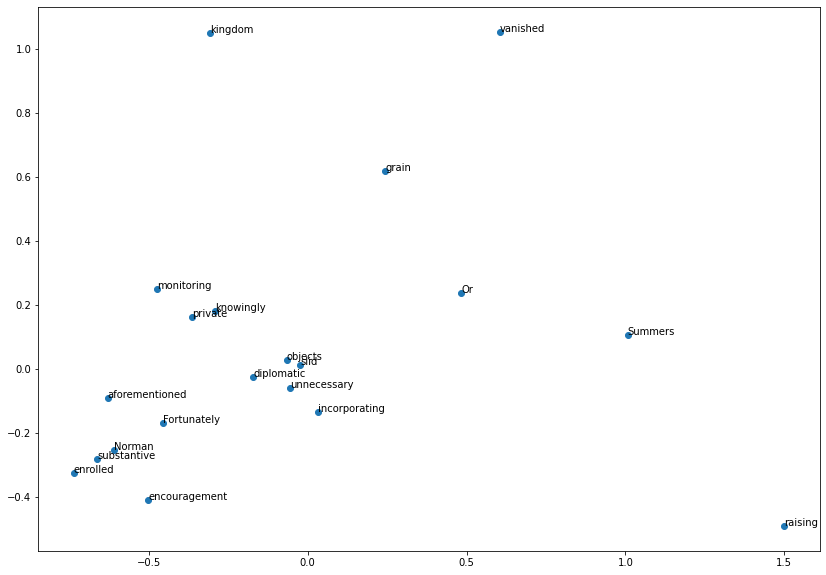

In [22]:
plt.figure(figsize=(14, 10))

res = random.sample(range(1, len(all_words)), 20) 

vocab = model_emb[all_words]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vocab)

plt.scatter(pca_results[res, 0], pca_results[res, 1])

words = list(model_emb.vocab)

for i, word in enumerate(words):
    if i in res:
        plt.annotate(word[:], xy=(pca_results[i, 0], pca_results[i, 1]))
plt.show()

#### Remove NaN

In [23]:
print(tweets.shape)
tweets['FastTextNan'] = tweets['FastText']
tweets['FastTextNan'] = np.array([k.tolist() for k in tweets.FastText.values]) 
print(tweets.shape)

(18009, 8)
(18009, 9)


In [24]:
print(tweets.shape)

tweets.dropna(inplace=True)

print(tweets.shape)

(18009, 9)
(18008, 9)


### Training of the Model

In [25]:
X = np.array([k.tolist() for k in tweets.FastText.values])

X_train, X_test, y_train, y_test = train_test_split(X, tweets.label.values, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

#[print(dat[:3], dat.shape, end="\n"*2) for dat in [X_train, X_test, y_train, y_test]];



In [26]:
X_train.shape

(14406, 300)

In [27]:
params = {'C':1, 'max_iter':1000, 'multi_class' :"ovr", 'solver':'saga'}


model = LogisticRegression(**params) # use all CPUs

model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
pred = model.predict(X_test)

accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f0_5 = fbeta_score(y_test,pred,beta=0.5)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)

print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F0_5_score: {}'.format(round(f0_5,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))

Accuracy: 0.8584
Precision: 0.8814
Recall: 0.8798
F0_5_score: 0.8811
F1_score: 0.8806
F2_score: 0.8801


Average precision-recall score: 0.94


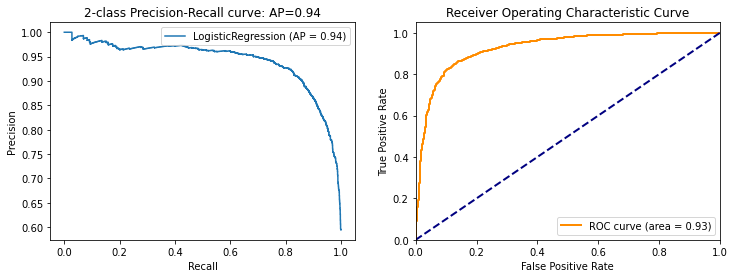

In [29]:
y_score = model.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fig, axes = plt.subplots(figsize=(12,4),nrows=1,ncols=2)
disp = plot_precision_recall_curve(model, X_test, y_test,ax=axes[0])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
axes[0].legend(loc="upper right")


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#plt.figure()
lw = 2
axes[1].plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic Curve')
axes[1].legend(loc="lower right")
plt.show()